In [9]:
from functools import partial
from itertools import product

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

from tensorflow.keras import utils

%matplotlib inline

In [10]:
dftrain = pd.read_csv('../../data/train.csv', sep='|')
dftrain.insert(1, 'totalItemsScanned', dftrain['scannedLineItemsPerSecond'] * dftrain['totalScanTimeInSeconds'])
dftrain = dftrain.drop(columns=[
    'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition', 'valuePerSecond',
    'quantityModifications', 'grandTotal'
])

n_classes = 2
y_train = dftrain.pop('fraud')
dataset = tf.data.Dataset.from_tensor_slices((dftrain.values, y_train.values))
train_dataset = dataset.shuffle(len(dftrain)).batch(1)

In [65]:
# Custom loss function with costs
def w_categorical_crossentropy(y_true, y_pred, weights, sample_weight):
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = tf.dtypes.cast(K.equal(y_pred, y_pred_max), tf.int32)
    y_true_float32 = tf.dtypes.cast(y_true, tf.float32)
    y_true_int32 = tf.dtypes.cast(y_true, tf.int32)

    y_pred_one_hot = tf.one_hot(y_pred_max_mat, 2, axis=1)
    y_true_one_hot = tf.one_hot(y_true_int32, 2, axis=1)

    for c_p, c_t in product(range(n_classes), range(n_classes)):
        final_mask += (weights[c_t, c_p] * y_pred_one_hot[:, c_p, 0] * y_true_one_hot[:, c_t, 0])

    return K.sum(K.binary_crossentropy(y_pred, y_true_float32) * final_mask)


w_array = np.ones((n_classes, n_classes))
w_array[0, 0] = 1
w_array[1, 0] = 1.1
w_array[1, 1] = 1
w_array[0, 1] = 1.3

# normalize
#w_array = (w_array - np.min(w_array)) / np.ptp(w_array)

ncce = partial(w_categorical_crossentropy, weights=w_array)

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [73]:
epochs = 5
#model.compile(loss=ncce, optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(train_dataset, epochs=epochs, verbose=1)

Epoch 1/5
1879/1879 [==============================] - 5s 3ms/step - loss: 9.8341 - accuracy: 0.8957
Epoch 2/5
1879/1879 [==============================] - 2s 1ms/step - loss: 2.7801 - accuracy: 0.8946
Epoch 3/5
1879/1879 [==============================] - 2s 1ms/step - loss: 0.9575 - accuracy: 0.8978
Epoch 4/5
1879/1879 [==============================] - 2s 1ms/step - loss: 0.3403 - accuracy: 0.9175
Epoch 5/5
1879/1879 [==============================] - 2s 1ms/step - loss: 0.2349 - accuracy: 0.9377


{'loss': [9.834116600422043, 2.778633853230241, 0.9570287946657641, 0.3400851373888518, 0.2348152811259939], 'accuracy': [0.8956892, 0.8946248, 0.89781797, 0.9175093, 0.9377328]}


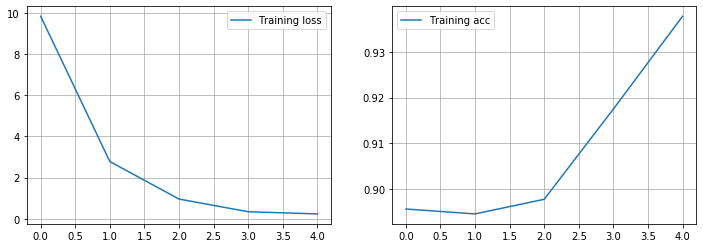

In [74]:
print(log.history)
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
#ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
#ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [61]:
dftest = pd.read_csv('../../data/test.csv', sep='|')
dftest.insert(1, 'totalItemsScanned', dftest['scannedLineItemsPerSecond'] * dftest['totalScanTimeInSeconds'])
dftest = dftest.drop(columns=[
    'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition', 'valuePerSecond',
    'quantityModifications', 'grandTotal'
])

X_test = dftest.values
y_test = pd.read_csv('../../data/DMC-2019-realclass.csv').values


In [75]:
y_pred = model.predict_proba(X_test)[:,0]

In [44]:
def score_evaluation(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    score = 0
    score += conf[0][1] * -25
    score += conf[1][0] * -5
    score += conf[1][1] * 5

    return score

0.01 -4775640
0.11 -836345
0.21 -277585
0.31 -133375
0.41 -118635
0.51 -118635
0.61 -118635
0.71 -118635
0.81 -118635
0.91 -118635
0
-10000


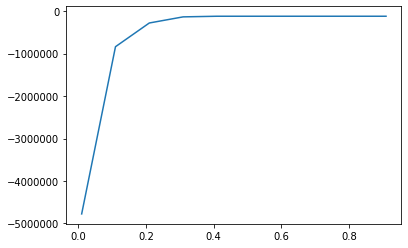

In [78]:
best_thresh = 0
max_score = -10000

thresholds = []
scores = []

for thresh in range(1, 100, 10):
    thresh = thresh / 100

    y_pred_local = y_pred.copy()
    y_pred_local[y_pred_local >= thresh] = 1
    y_pred_local[y_pred_local < thresh] = 0

    score = score_evaluation(y_test, y_pred_local)
    
    thresholds.append(thresh)
    scores.append(score)
    
    print(thresh, score)
    
    if score > max_score:
        best_thresh = thresh
        max_score = score

plt.plot(thresholds, scores)

print(best_thresh)
print(max_score)